In [1]:
import os, sys, time, resource, re, gc, shutil

mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"
    
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


from run_id import run_id

run_id = 1056

run_id = 1429

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

In [2]:
tsums = topics.aggregate(
    ip_score=Sum('ipcc_score'),
    score=Sum('ipcc_time_score')
)
tsums

topics.update(
    ipcc_share=F('ipcc_score')/tsums['ip_score'],
    share=F('ipcc_time_score')/tsums['score']
)

100

In [3]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [4]:



df = pd.DataFrame.from_dict(
    list(topics.values(
        'title',
        'score',
        'ipcc_coverage',
        'share',
        'ipcc_score',
        'ipcc_share',
        'ipcc_time_score',
        'primary_wg'
    ))
)

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation
51,0.038737,14.906927,0.002428,384.824126,3,888.949444,0.008688,"{waste, material, landfill}",-0.006260,0.006260,0.279475
26,0.042139,12.127539,0.001975,287.797204,3,562.197043,0.006498,"{coal, combustion, gasification}",-0.004522,0.004522,0.304021
61,0.047209,25.682415,0.004183,544.016391,2,928.483368,0.012282,"{sediment, deposit, erosion}",-0.008099,0.008099,0.340597
48,0.048345,2.326178,0.000379,48.116362,3,250.211054,0.001086,"{biochar, amendment, application}",-0.000707,0.000707,0.348792
16,0.054793,12.527975,0.002041,228.641868,3,530.763641,0.005162,"{oil, palm, biodiesel}",-0.003121,0.003121,0.395314


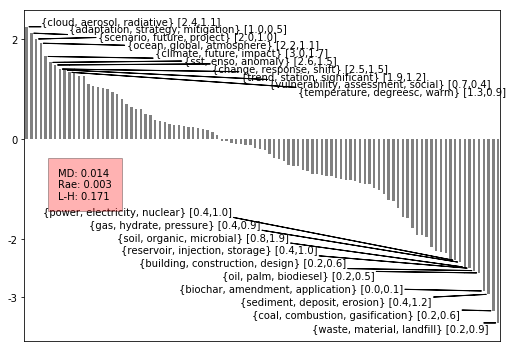

In [5]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [7.2,5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index()#.set_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax,color="grey")

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
if mp_pdf:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.pdf'.format(run_id),bbox_inches='tight')
else:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

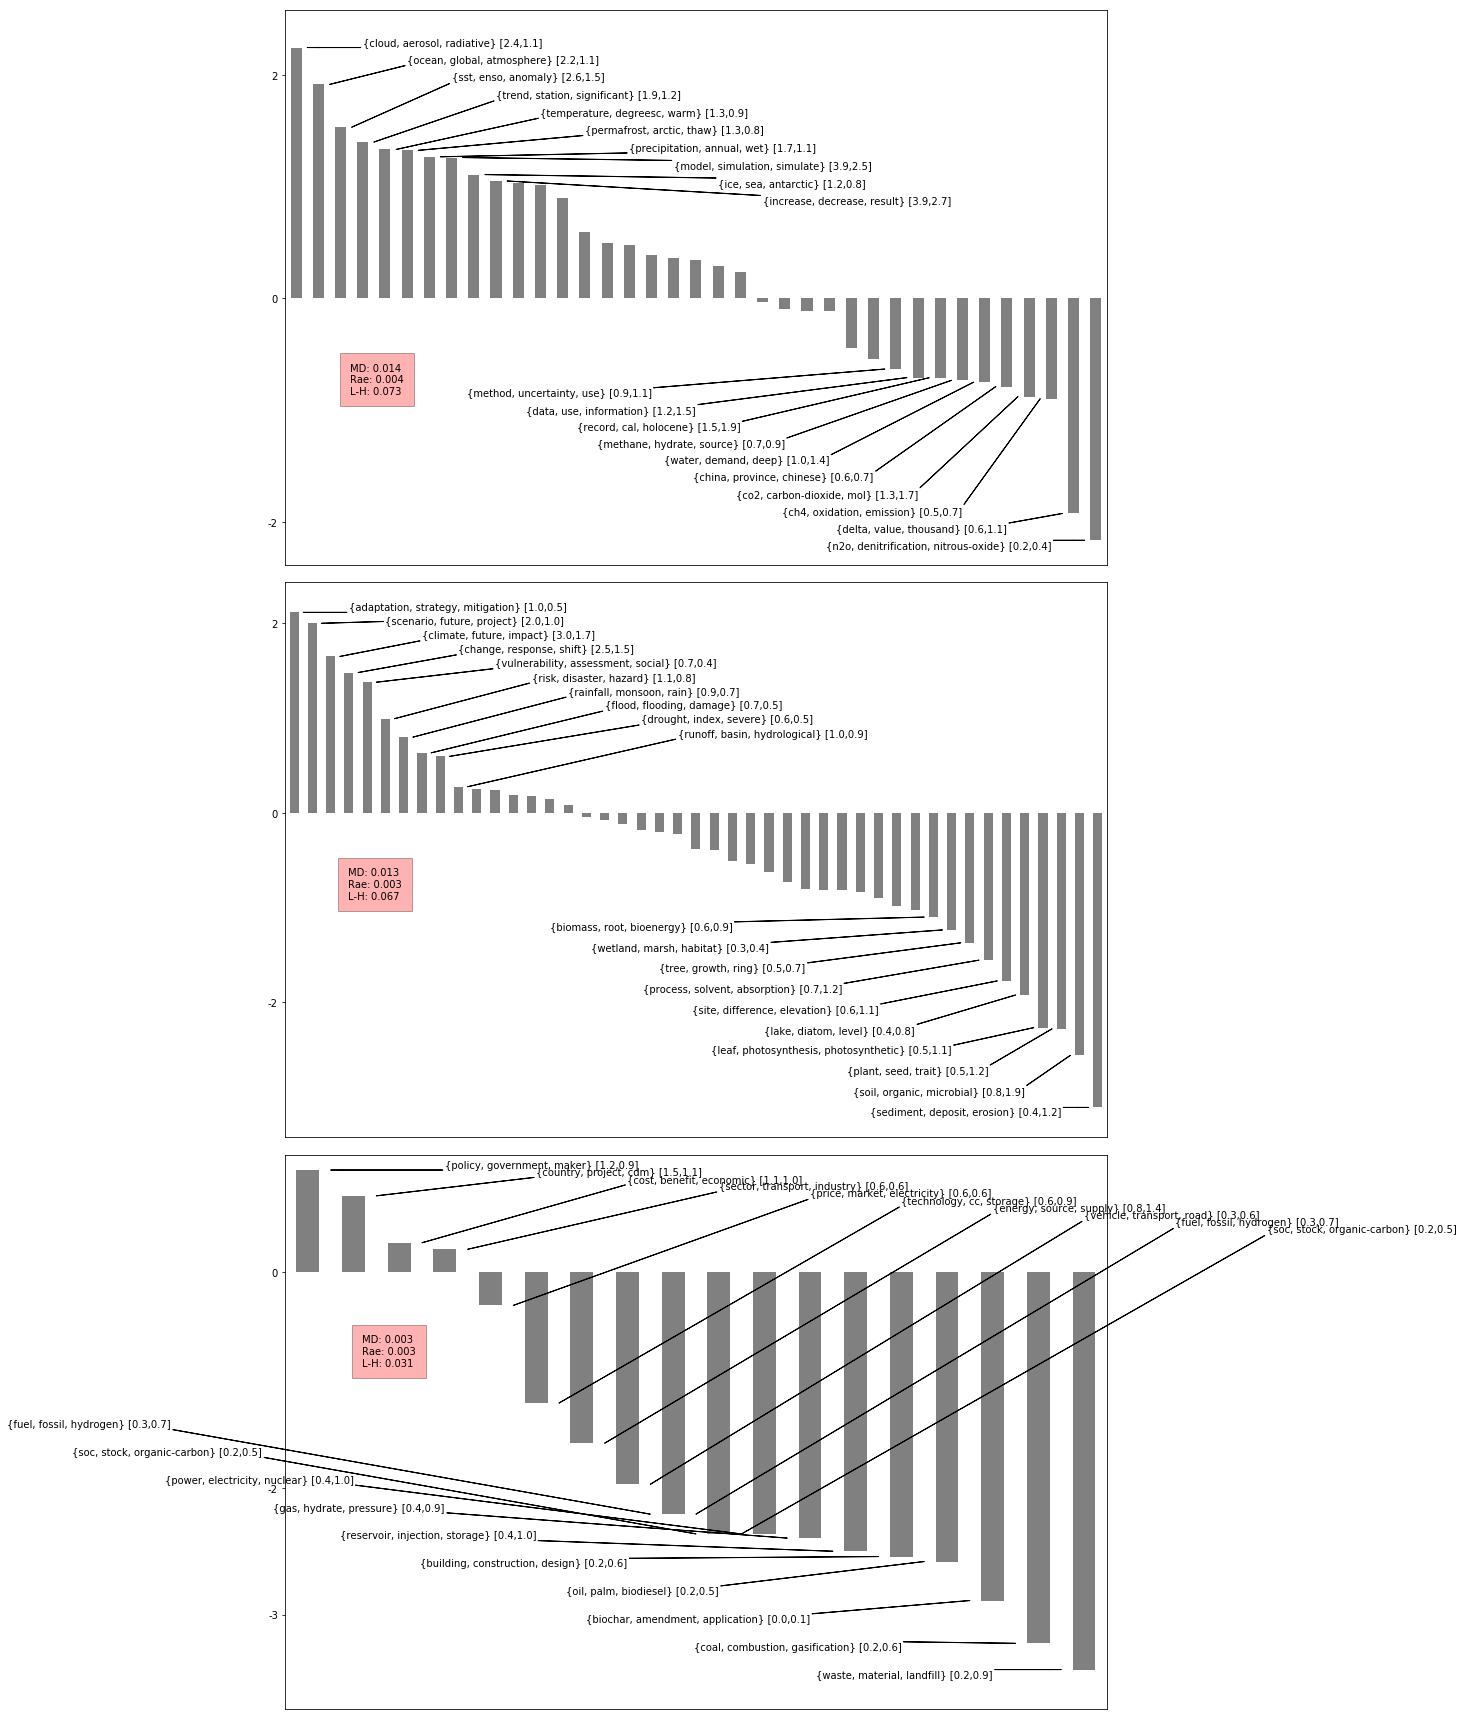

In [6]:
fig, axs = plt.subplots(3, figsize=(12,24))
for i, (name, group) in enumerate(df.groupby('primary_wg')):
    ax = axs[i]
    plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    
plt.tight_layout()
    #plt.savefig(f'../plots/ipcc_representation/ipcc_rep_{run_id}_wg_{}.pdf',bbox_inches='tight')

In [7]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.6931471805599453, 0]


plt.rcParams["figure.figsize"] = [16,12]

stat = RunStats.objects.get(pk=run_id)

fig = plt.figure()


disp = pd.DataFrame(columns=['AR','MD','Rae','L-H'])
#fig, axs = plt.subplots(2,3,sharey=True)

for i, tp in enumerate(stat.periods.filter(n__lt=6)):
    if i == 0:
        ax = fig.add_subplot(2,3,i+1)
        ax1 = ax
    else:
        ax = fig.add_subplot(2,3,i+1,sharey=ax1)
    print(tp)
    tdts = TimeDTopic.objects.filter(dtopic__run_id=run_id,period=tp)
    
    df = pd.DataFrame.from_dict(
        list(tdts.values(
            'dtopic__title',
            'score',
            'share',
            'ipcc_score',
            'ipcc_share',
            #'ipcc_time_score'
        ))
    )
    
    df = df.rename(columns={'dtopic__title':'title'})
    
    df, df_disp  = calculate_deviations(df)
    df_disp['AR'] = tp.title   
    disp = disp.append(pd.DataFrame.from_dict([df_disp]))

    plot_representation(df, ax, 2.3,1)
    
    ax.set_title(tp.title)
    
    if tp.title=="AR5":
        ax = fig.add_subplot(2,3,6)
        
        disp = disp.set_index('AR')
        
        disp.plot(ax=ax)
        
        ax.set_title("Disproportionality")
    
    
    
    #plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_{}.png'.format(run_id,tp.title),bbox_inches='tight')
    #plt.show()

plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_ARS.png'.format(run_id),bbox_inches='tight')
plt.show()

disp.head()

In [8]:
tds = topics.filter(timedtopic__period__n__lt=6).values(
    'title','timedtopic__period__title','timedtopic__period__n','timedtopic__score','score'
).order_by('id','timedtopic__period__n')

tdf = pd.DataFrame.from_dict(list(tds))

#tdf['ys'] = tdf[]

tdf['share'] = tdf['timedtopic__score'] / tdf['score']

tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']


tdf.head(12)
#tdf.groupby('')

,score,timedtopic__period__n,timedtopic__period__title,timedtopic__score,title,share,ys
0,500.278188,1,AR1,0.000000,"{irrigation, agricultural, farmer}",0.000000,0.000000
1,500.278188,2,AR2,2.790725,"{irrigation, agricultural, farmer}",0.005578,0.011157
2,500.278188,3,AR3,11.152046,"{irrigation, agricultural, farmer}",0.022292,0.066875
3,500.278188,4,AR4,22.044033,"{irrigation, agricultural, farmer}",0.044064,0.176254
4,500.278188,5,AR5,137.974599,"{irrigation, agricultural, farmer}",0.275796,1.378979
5,663.697541,1,AR1,0.224045,"{permafrost, arctic, thaw}",0.000338,0.000338
6,663.697541,2,AR2,3.762659,"{permafrost, arctic, thaw}",0.005669,0.011338
7,663.697541,3,AR3,21.115837,"{permafrost, arctic, thaw}",0.031815,0.095446
8,663.697541,4,AR4,75.069108,"{permafrost, arctic, thaw}",0.113107,0.452430
9,663.697541,5,AR5,248.247608,"{permafrost, arctic, thaw}",0.374037,1.870186


In [9]:
means = tdf.groupby('title')['ys'].mean()

means = pd.DataFrame({'ys' : tdf.groupby('title')['ys'].mean()}).reset_index()

mdf = df.merge(means)

mdf.head()

means.sort_values('ys',ascending=False).head()



,title,ys
86,"{temperature, degreesc, warm}",0.643588
74,"{scale, spatial, large}",0.611498
99,"{year, period, annual}",0.602520
81,"{solar, cycle, activity}",0.557288
78,"{site, difference, elevation}",0.550687


In [10]:
for name, group in tdf.groupby('title'):
    l = []
    for index, y in group.iterrows():
        print(y.share)
        l = l + [y.timedtopic__period__n] * round(y.share*100)
        
    print(l)
    
    print(np.mean(l))
    
    mdf.loc[mdf['title']==name]['av_year'] = np.mean(l)
    
    break

1.8000855593689156e-05
0.0020559328551853356
0.024818901451241472
0.037441944710587795
0.3641305528472632
[3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
4.809523809523809


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
def year_av(x):
    group = tdf[tdf['title']==x['title']]
    l = []
    for index, y in group.iterrows():
        l = l + [y.timedtopic__period__n] * round(y.share*100)
    return np.mean(l)

mdf['year_av'] = df.apply(year_av,axis=1)

print(mdf[pd.isna(mdf['year_av'])].shape)

mdf.head()

(0, 13)


,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av
0,0.080905,41.764339,0.006803,516.213807,2,1071.886368,0.011655,"{process, solvent, absorption}",-0.004852,0.004852,0.583704,0.439563,4.659574
1,0.105077,28.899330,0.004707,275.030406,2,1102.282304,0.006209,"{design, problem, propose}",-0.001502,0.001502,0.758095,0.226659,4.666667
2,0.097108,23.207193,0.003780,238.983460,2,473.660163,0.005396,"{groundwater, recharge, aquifer}",-0.001615,0.001615,0.700602,0.464752,4.714286
3,0.090353,17.452483,0.002843,193.158187,2,398.847820,0.004361,"{wetland, marsh, habitat}",-0.001518,0.001518,0.651870,0.432486,4.574468
4,0.130425,34.920825,0.005688,267.747093,2,587.223637,0.006045,"{coral, reef, fish}",-0.000357,0.000357,0.940972,0.422997,4.795455


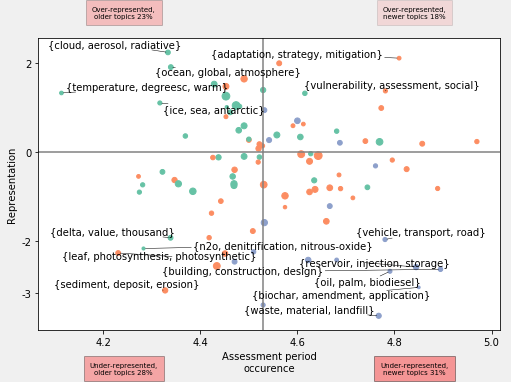

In [12]:
x = 'year_av'
y = 'representation'
y = 'lrep'

mdf['lrep'] = np.log(mdf['representation'])

fig, ax = plt.subplots()

cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


mdf.plot.scatter(
    x,y,s=mdf['score']*0.03,
    c = colors,ax=ax
)


# Fit a trendline
#z = np.polyfit(x=mdf[x], y=mdf[y], deg=1)
#p = np.poly1d(z)
#mdf['trendline'] = p(mdf.loc[:, x])
#plt.plot(mdf[x],mdf['trendline'])


# Quantile x and y
qs = 6
mdf['x_q'] = pd.qcut(mdf[x], qs, labels=False)
mdf['y_q'] = pd.qcut(mdf[y], qs, labels=False)
texts = []

# write texts for dots in outer quantiles
for i, row in mdf[(mdf['x_q'].isin([0,qs-1])) & (mdf['y_q'].isin([0,qs-1]))].iterrows(): 
    texts.append(plt.text(row[x],row[y],row['title'],ha='center', va='center'))
    
# Tweak the labels to avoid overlap    
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)


# Split the graph into quadrants
ymid = 0
plt.axhline(ymid,c="grey")
plt.axvline(mdf[x].median(),c="grey")



# Put labels on the quadrants
# x
d1 = mdf[x].median()-plt.xlim()[0]
d2 = mdf[x].median()-plt.xlim()[1]

xlabpoints = [mdf[x].median()-d1/2,mdf[x].median()-d2/2]
xrange = mdf[x].max()-mdf[x].min()
xlabpoints = [mdf[x].min()+xrange*0.15,mdf[x].min()+xrange*0.85]
labels = [
    ['Under-represented,\nolder topics','Under-represented,\nnewer topics'],
    ['Over-represented,\nolder topics','Over-represented,\nnewer topics']
]

pylims = plt.ylim()

tpad = (pylims[1]-pylims[0])*0.13


ops = [operator.lt,operator.gt]


for i in [0,1]:
    for j in [0,1]:
        if j==0:
            tpadx=tpad*-1
        else:
            tpadx=tpad*0.66

            
        q = mdf[(ops[i](mdf[x],mdf[x].median())) & (ops[j](mdf[y],ymid))]
        qshare = q['score'].sum()/mdf['score'].sum()
        plt.text(
            xlabpoints[i],
            pylims[j]+tpadx,
            labels[j][i] + " {:.0%}".format(qshare),
            va="center",ha="center",
            bbox={'facecolor':'red', 'alpha':qshare*2-0.25, 'pad':6},
            fontsize=7
        )

        
fmax = None
fmin = None
rmax = mdf['lrep'].max()
if fmax:
    rmax = fmax
rmin = mdf['lrep'].min()
if fmin:
    rmin = -fmin
    
if rmin > -1:
    rmin = -1
if np.exp(rmax) < 2:
    rmax = np.log(2.1)

lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)



ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
yticks = []
for x in ytick_labels:
    if x < 0:
        y = np.log(-1/x)
    elif x==0:
        y = 0
    else:
        y = np.log(x)
    yticks.append(y)
    
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

#ax.get_yaxis().set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax2.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Assessment period\noccurence')
plt.ylabel('Representation')

plt.tight_layout(h_pad=100)

fig.patch.set_facecolor('#f0f0f0')    


plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_new{}_all.{}'.format(run_id,extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

In [13]:
plt.close()

In [14]:
mdf.sort_values('year_av', ascending=False).tail(15)

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av,lrep,x_q,y_q
73,0.157320,70.607529,0.011501,448.813986,1,665.481438,0.010133,"{solar, cycle, activity}",0.001368,0.001368,1.135014,0.557288,4.369231,0.126645,0,4
24,0.108388,89.466948,0.014573,825.434124,1,1292.687247,0.018636,"{record, cal, holocene}",-0.004063,0.004063,0.781982,0.539941,4.354839,-0.245923,0,2
22,0.111613,53.032683,0.008638,475.145790,2,929.652205,0.010727,"{rate, decomposition, litter}",-0.002089,0.002089,0.805255,0.427159,4.346939,-0.216596,0,2
36,0.269145,132.358757,0.021559,491.775772,1,771.399719,0.011103,"{ocean, global, atmosphere}",0.010457,0.010457,1.941790,0.496072,4.339286,0.663610,0,5
85,0.071148,34.720163,0.005655,487.999752,1,772.941506,0.011018,"{delta, value, thousand}",-0.005362,0.005362,0.513309,0.537148,4.338710,-0.666877,0,0
52,0.301816,149.729127,0.024389,496.094477,1,747.272726,0.011200,"{cloud, aerosol, radiative}",0.013188,0.013188,2.177503,0.513448,4.333333,0.778179,0,5
61,0.047209,25.682415,0.004183,544.016391,2,928.483368,0.012282,"{sediment, deposit, erosion}",-0.008099,0.008099,0.340597,0.499970,4.327586,-1.077056,0,0
87,0.118946,55.371250,0.009019,465.515622,1,772.692694,0.010510,"{flux, surface, measurement}",-0.001491,0.001491,0.858157,0.502261,4.322034,-0.152968,0,2
99,0.203533,74.036524,0.012059,363.757278,1,560.384596,0.008213,"{ice, sea, antarctic}",0.003847,0.003847,1.468423,0.522019,4.316667,0.384189,0,5
60,0.065460,11.167987,0.001819,170.609058,1,313.575823,0.003852,"{n2o, denitrification, nitrous-oxide}",-0.002033,0.002033,0.472269,0.457848,4.283019,-0.750206,0,0


In [15]:
mdf = mdf.sort_values(['primary_wg','year_av'],ascending=False).reset_index(drop=True)

mdf.head()

mdf[['ipcc_share','share','representation','primary_wg','title','year_av']].to_latex(
    '../tables/ipcc_shares_time.tex',
    index_names=False,
)

In [16]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    #{'wc__oecd': None}
]

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd=c['wc__oecd'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[i]
    
oecd_df = pd.DataFrame.from_dict(oecd_cats)

oecd_df.head()

,color,ipcc_share,share,wc__oecd
0,#7fc97f,0.046383,0.094130,Agricultural Sciences
1,#beaed4,0.066105,0.148603,Engineering and Technology
2,#fdc086,0.001372,0.002966,Humanities
3,#ffff99,0.018114,0.018082,Medical and Health Sciences
4,#386cb0,0.800039,0.607574,Natural Sciences


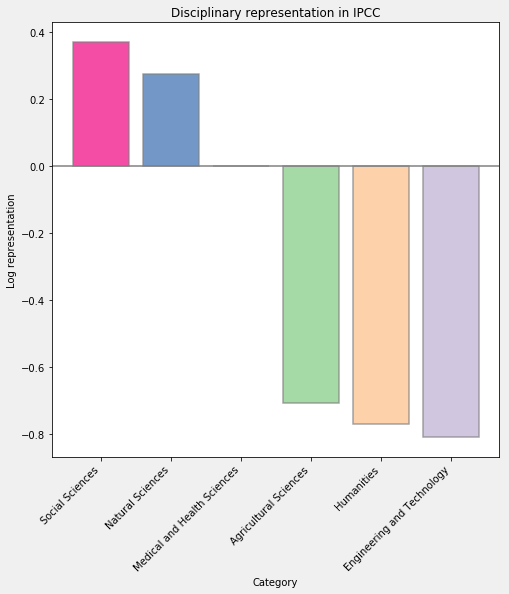

In [17]:
oecd_df['representation'] = oecd_df['ipcc_share'] / oecd_df['share']

oecd_df['lrep'] = np.log(oecd_df['representation'])

oecd_df = oecd_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    oecd_df.index, 
    oecd_df['lrep'],
    color=oecd_df['color'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey"
)

ax.set_xticks(oecd_df.index)
ax.set_xticklabels(oecd_df['wc__oecd'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('#f0f0f0')    


In [18]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]



oecd_df = pd.DataFrame()

ar_oe_cats = []

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(oecd_cats):
        d = {"wc__oecd": c["wc__oecd"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd=c['wc__oecd'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[i]
        
        ar_oe_cats.append(d)

oecd_df_ys = pd.DataFrame.from_dict(ar_oe_cats)

oecd_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,share,wc__oecd
0,1,#7fc97f,0.021429,0.060840,Agricultural Sciences
1,1,#beaed4,0.014286,0.061697,Engineering and Technology
2,1,#fdc086,0.000000,0.008569,Humanities
3,1,#ffff99,0.000000,0.017995,Medical and Health Sciences
4,1,#386cb0,0.964286,0.732648,Natural Sciences


In [19]:
oecd_df_ys['representation'] = oecd_df_ys['ipcc_share'] / oecd_df_ys['share']

oecd_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,share,wc__oecd,representation
2,1,#fdc086,0.000000,0.008569,Humanities,0.000000
3,1,#ffff99,0.000000,0.017995,Medical and Health Sciences,0.000000
5,1,#f0027f,0.000000,0.041988,Social Sciences,0.000000
16,3,#fdc086,0.000000,0.001576,Humanities,0.000000
9,2,#fdc086,0.000000,0.001288,Humanities,0.000000
13,2,#F0F0F0,0.000805,0.108092,None,0.007443
34,5,#F0F0F0,0.001521,0.111872,None,0.013596
27,4,#F0F0F0,0.005740,0.107584,None,0.053357
6,1,#F0F0F0,0.007143,0.120823,None,0.059119
20,3,#F0F0F0,0.009501,0.131081,None,0.072479


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


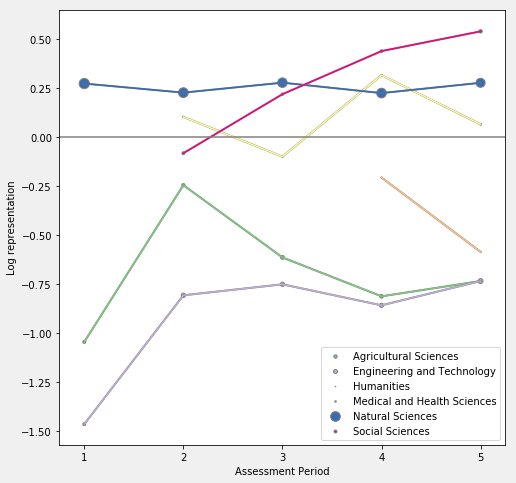

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

fdf = oecd_df_ys

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')

for name, group in fdf.groupby('wc__oecd'):
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    ax.plot(
        group['ar'],
        group['lrep'],
        label='_nolegend_',
        lw=2,
        color="grey"
    )
    ax.plot(
        group['ar'],
        group['lrep'],
        #label=name,
        label='_nolegend_',
        color=color
    )
    ax.scatter(
        group['ar'],
        group['lrep'],
        label=name,
        color=color,
        s = 150*group['s_share'],
        edgecolor="grey"
    )
    
    ax.set_xticks([1,2,3,4,5])
    
ax.axhline(0,c="grey")
    
plt.legend()


ax.set_xlabel('Assessment Period')
ax.set_ylabel('Log representation')

fig.patch.set_facecolor('#f0f0f0')    

plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_time.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


In [21]:
cats = list(WC.objects.distinct('oecd_fos_text').values('oecd_fos_text','oecd_fos','oecd'))
cats

[{'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Agriculture, forestry, and fisheries'},
 {'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Animal and dairy science'},
 {'oecd': 'Humanities',
  'oecd_fos': '6',
  'oecd_fos_text': 'Art (arts, history of arts, performing arts, music)'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Basic medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Biological sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Chemical engineering'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Chemical sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Civil engineering'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Clinical medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Computer and 

In [32]:
q = runstat.query
colors = ['#386cb0','#beaed4','#ffff99','#7fc97f','#f0027f','#fdc086','#F0F0F0']

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd_fos_text=c['oecd_fos_text'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[int(c['oecd_fos'])-1]
    
    
cat_df = pd.DataFrame.from_dict(cats)

cat_df.head()

,color,ipcc_share,oecd,oecd_fos,oecd_fos_text,share
0,#7fc97f,0.038228,Agricultural Sciences,4,"Agriculture, forestry, and fisheries",0.078767
1,#7fc97f,0.001686,Agricultural Sciences,4,Animal and dairy science,0.004430
2,#fdc086,0.000039,Humanities,6,"Art (arts, history of arts, performing arts, m...",0.000494
3,#ffff99,0.000784,Medical and Health Sciences,3,Basic medicine,0.001992
4,#386cb0,0.119545,Natural Sciences,1,Biological sciences,0.171754


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


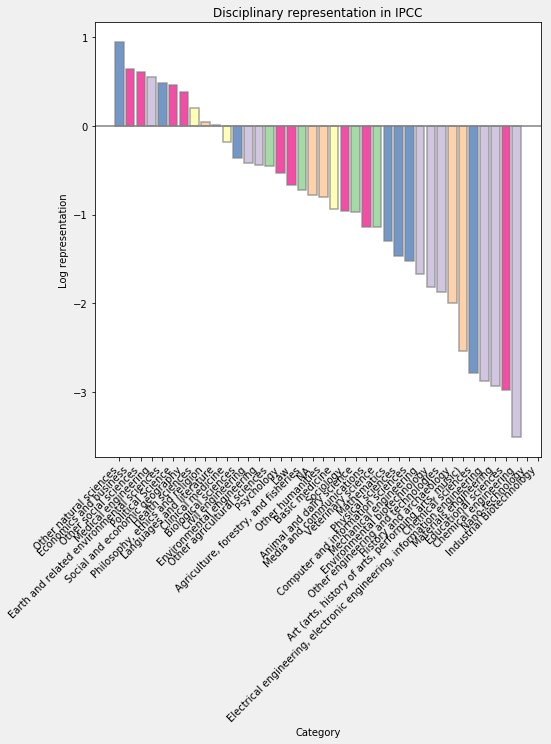

In [33]:
cat_df['representation'] = cat_df['ipcc_share'] / cat_df['share']

cat_df['lrep'] = np.log(cat_df['representation'])

cat_df = cat_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    cat_df.index, 
    cat_df['lrep'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey",
    color=cat_df['color']
)

ax.set_xticks(cat_df.index)
ax.set_xticklabels(cat_df['oecd_fos_text'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('#f0f0f0')    


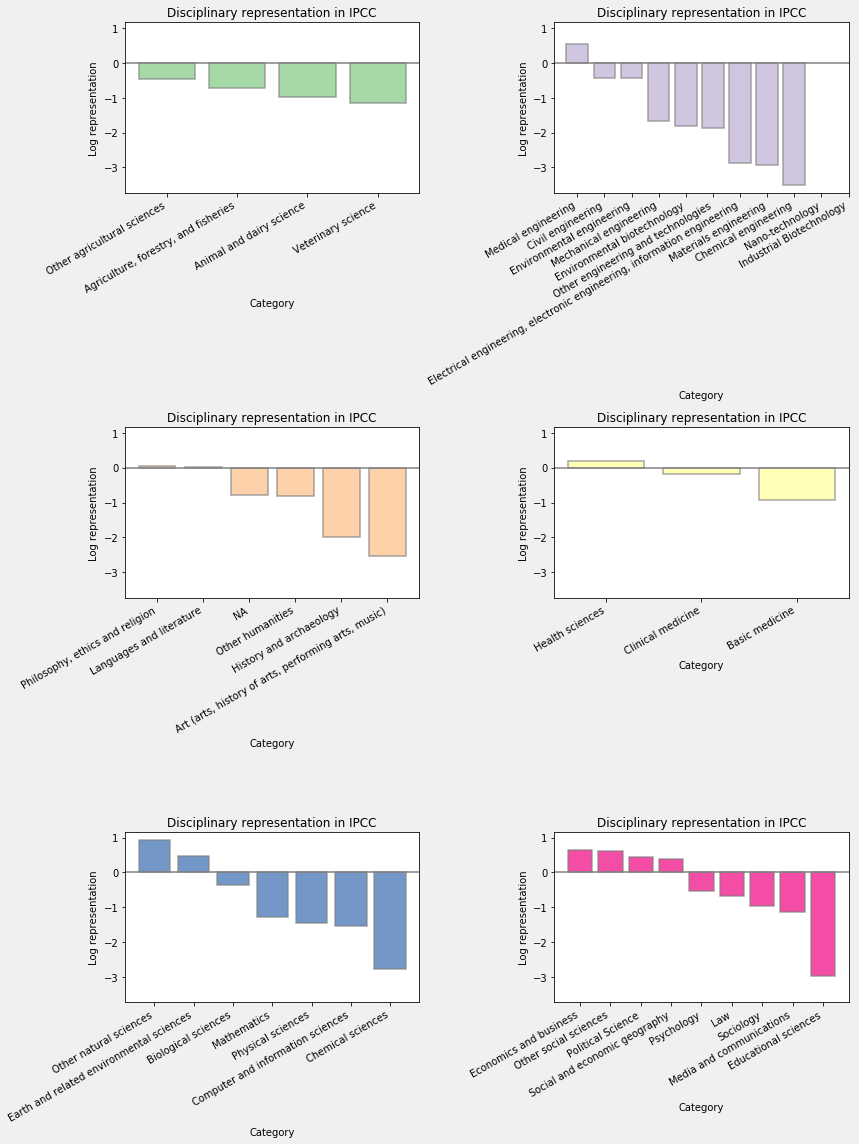

In [34]:
fig = plt.figure(figsize=(12,16))

ax = None

for i, (name, group) in enumerate(cat_df.groupby('oecd')):
    if ax:
        ax = fig.add_subplot(3,2,i+1, sharey=ax)
    else:
        ax = fig.add_subplot(3,2,i+1)
    group = group.reset_index(drop=True)
    ax.bar(
        group.index, 
        group['lrep'],
        alpha=0.7,
        linewidth=1.5,
        edgecolor="grey",
        color=group['color']
    )

    ax.set_xticks(group.index)
    ax.set_xticklabels(group['oecd_fos_text'])
    

    ax.set_xlabel('Category')
    ax.set_ylabel('Log representation')

    ax.axhline(0,c="grey")

    ax.set_title("Disciplinary representation in IPCC")

    plt.xticks()

    fig.patch.set_facecolor('#f0f0f0')    

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
fig.tight_layout()

plt.savefig("../plots/ippc_rep_subcats.png")

In [25]:
q = runstat.query

cat_df = pd.DataFrame()

ar_cats = []

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(cats):
        d = {"oecd_fos_text": c["oecd_fos_text"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd_fos_text=c['oecd_fos_text'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        d['oecd'] = c['oecd']
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[int(c['oecd_fos'])-1]
        
        
        ar_cats.append(d)

cat_df_ys = pd.DataFrame.from_dict(ar_cats)

cat_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,oecd,oecd_fos_text,share
0,1,#7fc97f,0.021429,Agricultural Sciences,"Agriculture, forestry, and fisheries",0.053128
1,1,#7fc97f,0.000000,Agricultural Sciences,Animal and dairy science,0.001714
2,1,#fdc086,0.000000,Humanities,"Art (arts, history of arts, performing arts, m...",0.000000
3,1,#ffff99,0.000000,Medical and Health Sciences,Basic medicine,0.002571
4,1,#386cb0,0.042857,Natural Sciences,Biological sciences,0.062554


In [35]:
cat_df_ys['representation'] = cat_df_ys['ipcc_share'] / cat_df_ys['share']

cat_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,oecd,oecd_fos_text,share,representation,lrep
64,2,#f0027f,0.0,Social Sciences,Media and communications,0.000586,0.0,-inf
52,2,#f0027f,0.0,Social Sciences,Educational sciences,0.001054,0.0,-inf
53,2,#beaed4,0.0,Engineering and Technology,"Electrical engineering, electronic engineering...",0.003630,0.0,-inf
54,2,#beaed4,0.0,Engineering and Technology,Environmental biotechnology,0.001757,0.0,-inf
57,2,#fdc086,0.0,Humanities,History and archaeology,0.001054,0.0,-inf
58,2,#beaed4,0.0,Engineering and Technology,Industrial Biotechnology,0.000351,0.0,-inf
60,2,#f0027f,0.0,Social Sciences,Law,0.000234,0.0,-inf
62,2,#386cb0,0.0,Natural Sciences,Mathematics,0.001522,0.0,-inf
73,2,#fdc086,0.0,Humanities,"Philosophy, ethics and religion",0.000234,0.0,-inf
76,2,#f0027f,0.0,Social Sciences,Psychology,0.001054,0.0,-inf


In [27]:
fdf['share'].sum()

5.243306147368636

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


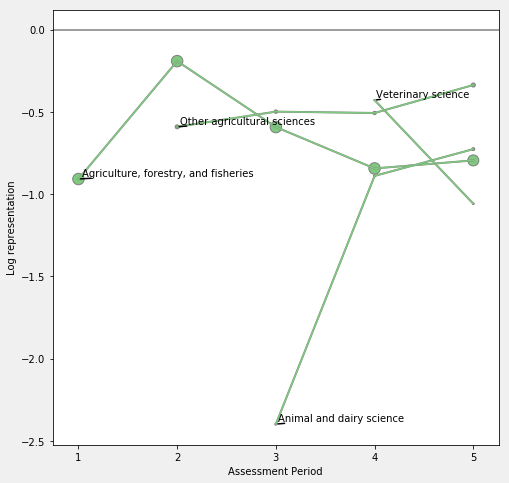

empty group
empty group


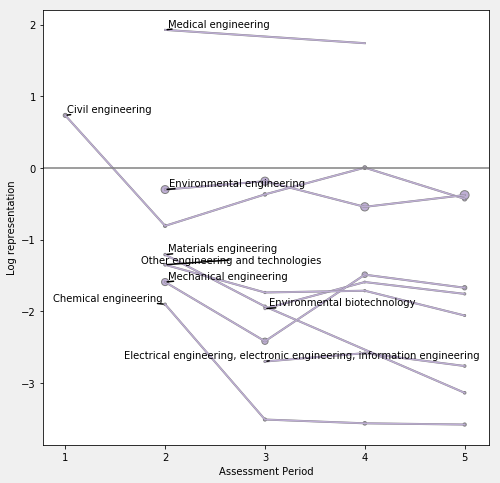

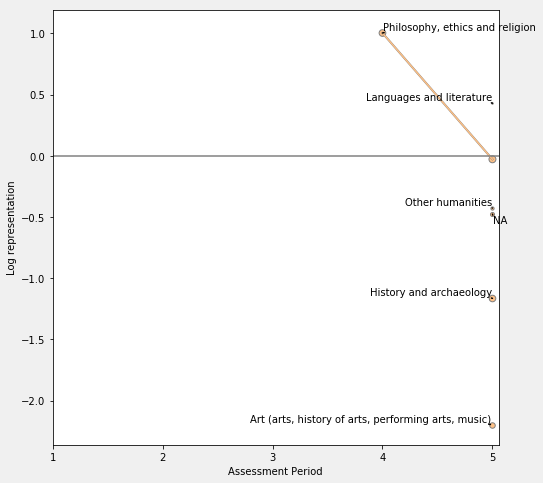

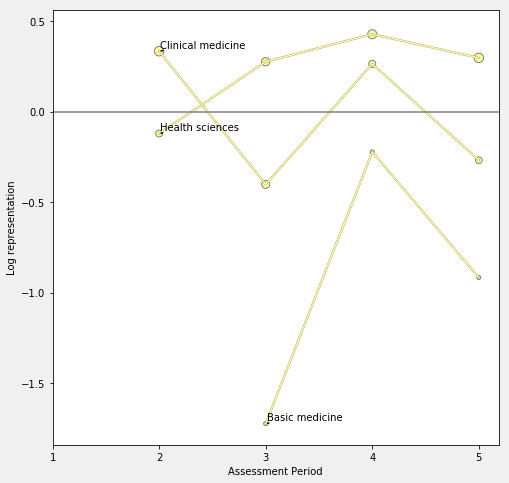

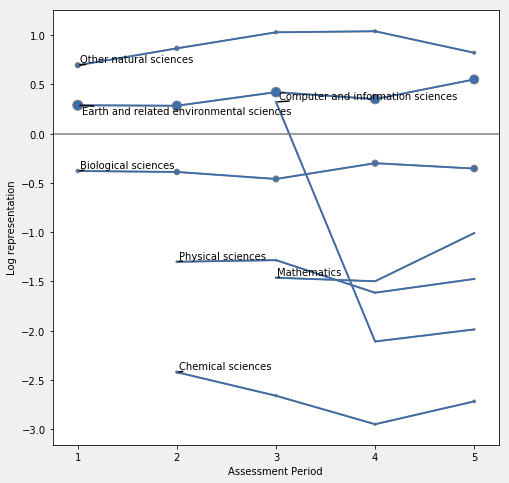

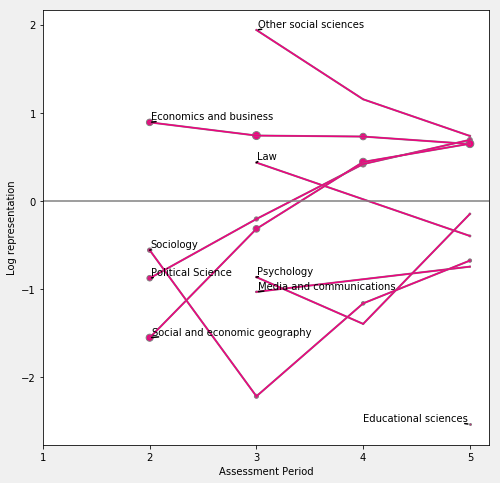

In [36]:

cat_df_ys['lrep'] = np.log(cat_df_ys['representation'])


for dis, fdf in cat_df_ys.groupby('oecd'):
    fig, ax = plt.subplots(figsize=(8,8))
    texts = []
    fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')
    
    for name, group in fdf.groupby('oecd_fos_text'):
        group['s_share'] = group['share'] / group['ar_share_total']
        group = group[np.isfinite(group['lrep'])].sort_values('ar').reset_index(drop=True)
        
        if len(group) == 0:
            print("empty group")
            continue

        color = group.reset_index()['color'][0]
        ax.plot(
            group['ar'],
            group['lrep'],
            label='_nolegend_',
            lw=2,
            color="grey"
        )
        ax.plot(
            group['ar'],
            group['lrep'],
            label=name,
            color=color
        )
        ax.scatter(
            group['ar'],
            group['lrep'],
            label=name,
            color=color,
            s = 150*group['s_share'],
            edgecolor="grey"
        )
        x = group['ar'][0] 
        y = group['lrep'][0]
        if np.isfinite(y):
            texts.append(
            ax.text(
                x,y,
                name
            )
            )

    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle="-", color='black', lw=1.5)
    )

    ax.set_xticks([1,2,3,4,5])

    ax.axhline(0,c="grey")

    #plt.legend()


    ax.set_xlabel('Assessment Period')
    ax.set_ylabel('Log representation')

    fig.patch.set_facecolor('#f0f0f0')    

    plt.savefig(
        f'../plots/ipcc_representation/ipcc_rep_cats_time_{dis}.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )
    
    plt.show()
    plt.close()


In [29]:
group

,ar,color,ipcc_share,oecd,oecd_fos_text,share,representation,lrep,ar_share_total,s_share
0,2,#f0027f,0.004023,Social Sciences,Sociology,0.007027,0.572473,-0.557791,0.056681,0.123967
1,3,#f0027f,0.000487,Social Sciences,Sociology,0.004466,0.109101,-2.215483,0.041032,0.108835
2,4,#f0027f,0.001325,Social Sciences,Sociology,0.004232,0.313008,-1.161525,0.051354,0.082412
3,5,#f0027f,0.003042,Social Sciences,Sociology,0.005981,0.508584,-0.676125,0.078931,0.075778
